In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time as t
from numba import jit

import astropy.units as u
import astropy.constants as c
from astroquery import atomic

import photontools
import bokeh


### plt parameters

In [2]:
%matplotlib inline
# %matplotlib notebook

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 15
plt.rcParams["figure.dpi"] = 72
# plt.rcParams["figure.dpi"] = 150
# plt.rcParams["figure.dpi"] = 300

lss = ['-', '--', '-.', ':']

In [3]:
bands_from_blue = np.array(["UVW2", "UVM2", "UVW1", "U", "B", "V", "R", "I", "J", "H", "K"])
color_from_blue = np.array([plt.cm.jet(i/bands_from_blue.size) for i in range(bands_from_blue.size)])
dict_color = dict(zip(bands_from_blue, color_from_blue))

### run parameters

In [25]:
filepath_he = "../../hewd/gamtmp.d"
filepath_co = "../../cowd/gamtmp.d"

directory_ML = "/Users/kawana/GoogleDrive/sync/study/yoshidalab/mypaper/0002_WD_TDE_radiation_transfer/WhiteDwarf_Thermonuclear_Transients/"
filepaths_spectra_ML = subprocess.getoutput('find "{}/WD06_spectra/" | grep ".par" | sort'.format(directory_ML)).split("\n")[1:]

vel_cowd = np.array([2.56466437e+03, 1.18143578e+04, -1.41779372e+00]) * 1e5
vel_hewd = np.array([4.49999438e+03, 1.54867843e+04, 1.27477734e+01]) * 1e5

system = "Vega"
# system = "AB"
# system = "ST"



In [5]:
filters = photontools.read_all_filters()
filter_focas, filter_johnson, filter_ps, filter_swift, filter_twomass = filters

./photontools/filter_data/focas
./photontools/filter_data/johnson
./photontools/filter_data/panstarrs
./photontools/filter_data/swift
./photontools/filter_data/twomass


In [6]:
# for i, filter in enumerate(filters):
#     list_bands = np.argsort(filter.effective_wavelength)
#     for j in list_bands:
#         plt.plot(filter.wavelengths[j], filter.response[j], label=filter.bands[j])
#     plt.title(filter.instrument)
#     plt.legend()
#     plt.show()
#     plt.close()


In [8]:
%time lc_ML, spectra_ML = photontools.read_MacLeod_data(directory=directory_ML, Force=False)


# binning lc to (theta, phi) = (10, 10)
lc_ML.data[:,:,:,1:] = 10**(-0.4 * lc_ML.data[:,:,:,1:])
lc_ML = lc_ML.binning(N_theta_bins=10, N_phi_bins=10)
lc_ML.data[:,:,:,1:] = -2.5*np.log10(lc_ML.data[:,:,:,1:])

# convert bolomotric luminosity to bolomotric magnitude
lc_ML_bol = lc_ML.bolometric_luminosity_to_magnitude()
lc_ML.data[:,:,:,0] = lc_ML_bol.data


CPU times: user 223 ms, sys: 99.3 ms, total: 322 ms
Wall time: 397 ms


In [9]:
%time spectra = photontools.read_Maeda_data(filepath_co)

# Doppler shift
%time spectra_shifted = spectra.Doppler_shift_by_intrinsic_velocity(vel_cowd)

# binning 
%time spectra_reduced = spectra_shifted.binning(N_theta_bins=10, N_phi_bins=10, every_wavelength=5)

CPU times: user 5.49 s, sys: 11.1 s, total: 16.5 s
Wall time: 20.6 s
CPU times: user 25.4 s, sys: 8.21 s, total: 33.6 s
Wall time: 53 s
CPU times: user 3.64 s, sys: 2.56 s, total: 6.2 s
Wall time: 6.94 s


In [10]:
print("MacLeod", spectra_ML.data.shape)
print("time\n",spectra_ML.times)
print("theta\n",spectra_ML.thetas)
print("phi\n",spectra_ML.phis)


MacLeod (16, 10, 10, 600)
time
 [ 4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 36. 40.]
theta
 [0.25892134 0.69716304 0.96834183 1.19537426 1.40334944 1.60413735
 1.80630233 2.01898641 2.25665138 2.55590903]
phi
 [0.1047 0.733  1.3614 1.9897 2.618  3.2463 3.8746 4.5029 5.1313 5.7596]


In [11]:
print("Maeda", spectra_reduced.data.shape)
print("time",spectra_reduced.times.size, "\n",spectra_reduced.times)
print("theta", spectra_reduced.thetas.size, "\n",spectra_reduced.thetas)
print("phi", spectra_reduced.phis.size, "\n",spectra_reduced.phis)


Maeda (71, 10, 10, 600)
time 71 
 [ 3.23593657  3.38844156  3.54813388  3.71535228  3.89045143  4.07380275
  4.26579516  4.46683589  4.67735137  4.89778815  5.12861378  5.3703179
  5.62341318  5.88843647  6.16594993  6.45654219  6.76082964  7.07945772
  7.41310227  7.76247101  8.12830499  8.51138019  8.91250917  9.33254278
  9.77237196 10.23292965 10.71519276 11.22018423 11.7489752  12.30268733
 12.88249511 13.48962839 14.12537497 14.79108337 15.48816564 16.21810038
 16.98243589 17.78279341 18.62087063 19.4984452  20.4173786  21.37961998
 22.38721041 23.4422871  24.54708803 25.70395662 26.91534675 28.18382793
 29.51209079 30.90295275 32.35936401 33.88441382 35.48133701 37.15352086
 38.90451232 40.73802545 42.6579494  44.66835657 46.77351131 48.97787894
 51.28613521 53.70317624 56.2341289  58.88436169 61.65949609 64.56541855
 67.60829291 70.79457352 74.1310189  77.62470611 81.28304572]
theta 10 
 [0.64350113 0.92729524 1.1592795  1.36943843 1.57079635 1.77215428
 1.98231321 2.21429748 2

In [18]:
system = "Vega"
# system = "AB"
# system = "ST"


lc_maeda_bol     = spectra_reduced.calc_bolometric_luminosity().bolometric_luminosity_to_magnitude()
lc_maeda_focas   = photontools.calc_band_flux(spectra_reduced, filters[0]).convert_flux_to_magnitude(filters[0], system=system)
lc_maeda_john    = photontools.calc_band_flux(spectra_reduced, filters[1]).convert_flux_to_magnitude(filters[1], system=system)
# lc_maeda_ps      = photontools.calc_band_flux(spectra_reduced, filters[2]).convert_flux_to_magnitude(filters[2], system=system)
lc_maeda_swift   = photontools.calc_band_flux(spectra_reduced, filters[3]).convert_flux_to_magnitude(filters[3], system=system)
lc_maeda_twomass = photontools.calc_band_flux(spectra_reduced, filters[4]).convert_flux_to_magnitude(filters[4], system=system)


/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/photons/analysis/python/photontools/photontools.py:572: RuntimeWarning: divide by zero encountered in log10
  new_lc.data  = -2.5 * np.log10(self.data[:,:,:] / c.L_bol0.cgs.value)
/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/photons/analysis/python/photontools/photontools.py:609: RuntimeWarning: divide by zero encountered in log10
  new_lc.data = -2.5 * np.log10(self.data / flux_zero_lambda / (4 * np.pi * distance.to(u.cm).value **2))
/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/photons/analysis/python/photontools/photontools.py:609: RuntimeWarning: invalid value encountered in log10
  new_lc.data = -2.5 * np.log10(self.data / flux_zero_lambda / (4 * np.pi * distance.to(u.cm).value **2))
/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/i

# mean lightcurve over theta and phi

Text(0.5, 1.0, 'solid: ours, dotted: MacLeod')

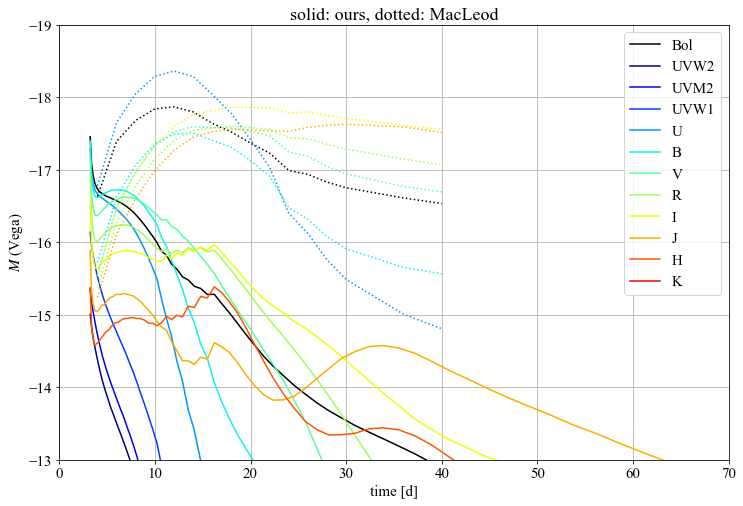

In [40]:

plt.figure(figsize=(12,8))

plt.plot(lc_maeda_bol.times, lc_maeda_bol.data[:,:,:].mean(axis=(1,2)), label="Bol", color="black")
# swift
list_index_bands = np.argsort(filter_swift.effective_wavelength)
for i in list_index_bands[:3]:
    band = lc_maeda_swift.bands[i]
    plt.plot(lc_maeda_swift.times, lc_maeda_swift.data[:,:,:,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

# #focas
# list_index_bands = np.argsort(filters[1].effective_wavelength)
# for i in list_index_bands:
#     band = lc_maeda_focas.bands[i][0].capitalize()
#     plt.plot(lc_maeda_focas.times, lc_maeda_focas.data[:,:,:,i].mean(axis=(1,2)), 
#              label=band,
#              color=dict_color[band])

#johnson
list_index_bands = np.argsort(filter_johnson.effective_wavelength)
for i in list_index_bands:
    band = lc_maeda_john.bands[i][0]
    plt.plot(lc_maeda_john.times, lc_maeda_john.data[:,:,:,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

#twomass
list_index_bands = np.argsort(filter_twomass.effective_wavelength)
for i in list_index_bands:
    band = lc_maeda_twomass.bands[i][0].capitalize()
    plt.plot(lc_maeda_twomass.times, lc_maeda_twomass.data[:,:,:,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

# plt.title("Maeda")
# plt.grid()
# plt.gca().invert_yaxis()
plt.legend()


plt.plot(lc_ML_bol.times, lc_ML_bol.data[:,:,:].mean(axis=(1,2)), label="Bol", color="black", linestyle=lss[3])
for i, band in enumerate(lc_ML.bands):
    if (i>0):
        plt.plot(lc_ML.times, lc_ML.data[:,:,:,i].mean(axis=(1,2)), 
    #                  label=band[1], 
                 color=dict_color[band[1]],
                 linestyle=lss[3])
    
# plt.title("MacLeod")
plt.xlabel("time [d]")
plt.ylabel(r"$M$ (Vega)")
plt.xlim(0,70)
plt.ylim(-19,-13)
plt.grid()
plt.gca().invert_yaxis()
plt.title("solid: ours, dotted: MacLeod")
# plt.legend()
# plt.savefig("figs/cowd/lc_compare.png")


# spectra at the direction opposite to ejecta velocity

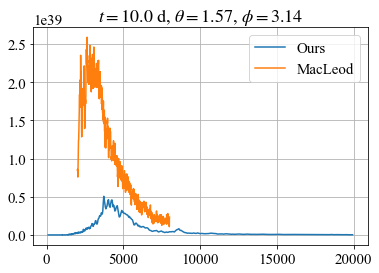

In [21]:
plt.figure(figsize=(6,4))

i_time=23
i_time_ed = 27
j_theta=4
k_phi=4

plt.title(r"$t = {:.1f}$ d, $\theta = {:.2f}$, $\phi = {:.2f}$".format(spectra_reduced.times[i_time:i_time_ed].mean(), spectra_reduced.thetas[j_theta], spectra_reduced.phis[k_phi]))

plt.plot(spectra_reduced.wavelengths, spectra_reduced.data[i_time:i_time_ed,j_theta,k_phi].mean(axis=0), label="Ours")

i_time=3
  
plt.plot(spectra_ML.wavelengths, spectra_ML.data[i_time,j_theta,k_phi], label="MacLeod")

plt.legend()
plt.grid()

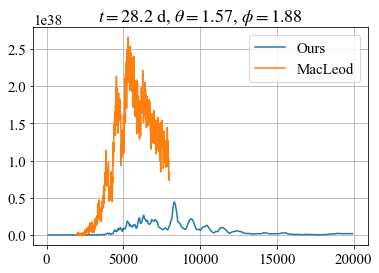

In [22]:
i_time=45
i_time_ed = 50
j_theta=4
k_phi=2

plt.title(r"$t = {:.1f}$ d, $\theta = {:.2f}$, $\phi = {:.2f}$".format(spectra_reduced.times[i_time:i_time_ed].mean(), spectra_reduced.thetas[j_theta], spectra_reduced.phis[k_phi]))

plt.plot(spectra_reduced.wavelengths, spectra_reduced.data[i_time:i_time_ed,j_theta,k_phi].mean(axis=0), label="Ours")

i_time=12

plt.plot(spectra_ML.wavelengths, spectra_ML.data[i_time,j_theta,k_phi], label="MacLeod")

plt.legend()
plt.grid()

# He WD

In [26]:
%time spectra = photontools.read_Maeda_data(filepath_he)

# Doppler shift
%time spectra_shifted = spectra.Doppler_shift_by_intrinsic_velocity(vel_hewd)

# binning 
%time spectra_reduced = spectra_shifted.binning(N_theta_bins=10, N_phi_bins=10, every_wavelength=5)

CPU times: user 5.44 s, sys: 10.3 s, total: 15.7 s
Wall time: 17.7 s
CPU times: user 22.4 s, sys: 6.59 s, total: 29 s
Wall time: 34.1 s
CPU times: user 3.35 s, sys: 1.7 s, total: 5.05 s
Wall time: 5.44 s


In [37]:
# system = "Vega"
system = "AB"
# system = "ST"


lc_maeda_bol     = spectra_reduced.calc_bolometric_luminosity().bolometric_luminosity_to_magnitude()
lc_maeda_focas   = photontools.calc_band_flux(spectra_reduced, filters[0]).convert_flux_to_magnitude(filters[0], system=system)
lc_maeda_john    = photontools.calc_band_flux(spectra_reduced, filters[1]).convert_flux_to_magnitude(filters[1], system=system)
# lc_maeda_ps      = photontools.calc_band_flux(spectra_reduced, filters[2]).convert_flux_to_magnitude(filters[2], system=system)
lc_maeda_swift   = photontools.calc_band_flux(spectra_reduced, filters[3]).convert_flux_to_magnitude(filters[3], system=system)
lc_maeda_twomass = photontools.calc_band_flux(spectra_reduced, filters[4]).convert_flux_to_magnitude(filters[4], system=system)


/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/photons/analysis/python/photontools/photontools.py:572: RuntimeWarning: divide by zero encountered in log10
  new_lc.data  = -2.5 * np.log10(self.data[:,:,:] / c.L_bol0.cgs.value)
/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/photons/analysis/python/photontools/photontools.py:609: RuntimeWarning: divide by zero encountered in log10
  new_lc.data = -2.5 * np.log10(self.data / flux_zero_lambda / (4 * np.pi * distance.to(u.cm).value **2))
/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/photons/analysis/python/photontools/photontools.py:609: RuntimeWarning: invalid value encountered in log10
  new_lc.data = -2.5 * np.log10(self.data / flux_zero_lambda / (4 * np.pi * distance.to(u.cm).value **2))
/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/i

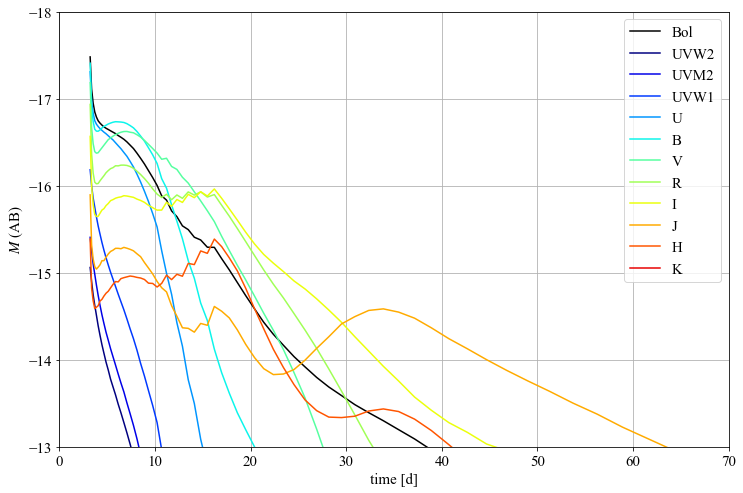

In [39]:
j_theta=0
j_theta_ed=-1
k_phi=0
k_phi_ed=-1


plt.figure(figsize=(12,8))

plt.plot(lc_maeda_bol.times, lc_maeda_bol.data[:,j_theta:j_theta_ed,k_phi:k_phi_ed].mean(axis=(1,2)), label="Bol", color="black")
# swift
list_index_bands = np.argsort(filter_swift.effective_wavelength)
for i in list_index_bands[:3]:
    band = lc_maeda_swift.bands[i]
    plt.plot(lc_maeda_swift.times, lc_maeda_swift.data[:,j_theta:j_theta_ed,k_phi:k_phi_ed,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

# #focas
# list_index_bands = np.argsort(filters[1].effective_wavelength)
# for i in list_index_bands:
#     band = lc_maeda_focas.bands[i][0].capitalize()
#     plt.plot(lc_maeda_focas.times, lc_maeda_focas.data[:,j_theta:j_theta_ed,k_phi:k_phi_ed,i].mean(axis=(1,2)), 
#              label=band,
#              color=dict_color[band])

#johnson
list_index_bands = np.argsort(filter_johnson.effective_wavelength)
for i in list_index_bands:
    band = lc_maeda_john.bands[i][0]
    plt.plot(lc_maeda_john.times, lc_maeda_john.data[:,j_theta:j_theta_ed,k_phi:k_phi_ed,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

#twomass
list_index_bands = np.argsort(filter_twomass.effective_wavelength)
for i in list_index_bands:
    band = lc_maeda_twomass.bands[i][0].capitalize()
    plt.plot(lc_maeda_twomass.times, lc_maeda_twomass.data[:,j_theta:j_theta_ed,k_phi:k_phi_ed,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

# plt.title("Maeda")
# plt.grid()
# plt.gca().invert_yaxis()
plt.legend()


# plt.plot(lc_ML_bol.times, lc_ML_bol.data[:,j_theta:j_theta_ed,k_phi:k_phi_ed].mean(axis=(1,2)), label="Bol", color="black", linestyle=lss[3])
# for i, band in enumerate(lc_ML.bands):
#     if (i>0):
#         plt.plot(lc_ML.times, lc_ML.data[:,j_theta:j_theta_ed,k_phi:k_phi_ed,i].mean(axis=(1,2)), 
#     #                  label=band[1], 
#                  color=dict_color[band[1]],
#                  linestyle=lss[3])
    
# plt.title("MacLeod")
plt.xlabel("time [d]")
plt.ylabel(r"$M$ (AB)")
plt.xlim(0,70)
plt.ylim(-18,-13)
plt.grid()
plt.gca().invert_yaxis()
# plt.title("solid: ours, dotted: MacLeod")
# plt.legend()
# plt.savefig("figs/hewd/lc_mean_AB.png")


# spectra

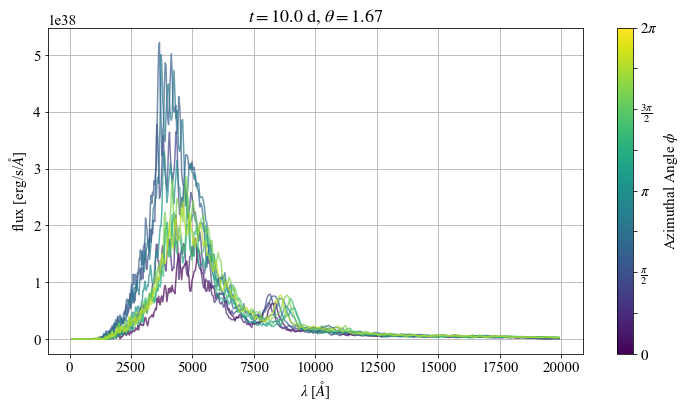

In [90]:
plt.figure(figsize=(12,6))
mycolor=plt.cm.viridis

i_time=24
i_time_ed = 26
j_theta=4
j_theta_ed=6
k_phi=0
k_phi_ed=-1


for k_phi in range(spectra_reduced.phis.size):
    k_phi_ed = k_phi + 1
    plt.plot(spectra_reduced.wavelengths, spectra_reduced.data[i_time:i_time_ed,j_theta:j_theta_ed,k_phi:k_phi_ed].mean(axis=(0,1,2)), 
             alpha=0.7, color=mycolor(k_phi / spectra_reduced.phis.size))


# create a colorbar
sm = plt.cm.ScalarMappable(cmap=mycolor, norm=plt.Normalize(vmin=0, vmax=2*np.pi))
sm._A = []
cb = plt.colorbar(sm,label=r'Azimuthal Angle $\phi$ ',orientation='vertical',shrink=1.0)

myticks = np.linspace(0.,2.,9)*np.pi
mylabel = [r"$0$","",r"$\frac{\pi}{2}$","",r"$\pi$","",r"$\frac{3 \pi}{2}$","",r"$2 \pi$"]
cb.set_ticks(myticks)
cb.set_ticklabels(mylabel)

plt.title(r"$t = {:.1f}$ d, $\theta = {:.2f}$".format(spectra_reduced.times[i_time:i_time_ed].mean(), spectra_reduced.thetas[j_theta:j_theta_ed].mean()))
# plt.title(r"$t = {:.0f}$ d, $\theta = {:.2f}$".format(spectra_reduced.times[i_time:i_time_ed].mean(), spectra_reduced.thetas[j_theta:j_theta_ed].mean()))
# plt.title(r"$t = {:.1f}$ d, $\theta = {:.2f}$, $\phi = {:.2f}$".format(spectra_reduced.times[i_time:i_time_ed].mean(), spectra_reduced.thetas[j_theta:j_theta_ed].mean(), spectra_reduced.phis[k_phi:k_phi_ed].mean()))
plt.xlabel(r"$\lambda$ [$\AA$]")
plt.ylabel(r"flux [erg/s/$\AA$]")

plt.grid()

# plt.savefig("figs/hewd/spectra_t{:.0f}.png".format(spectra_reduced.times[i_time:i_time_ed].mean()))
